بسم الله 

** Importing liberies and frameworks **

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Load videos and Preprocessing : ** defines a function load_video that takes a path to a video file as input and returns a preprocessed version of the video frames as a list of TensorFlow tensors lets eplain this with a simple graphe *

Test the function (LOad_video)

In [2]:
def load_video(path:str) -> List[float]:
    cap=cv2.VideoCapture(path)
    frames=[]
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame=tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean=tf.math.reduce_mean(frames)
    std=tf.math.reduce_std(tf.cast(frames,tf.float32))
    return tf.cast((frames-mean),tf.float32)/std

In [3]:
path="/kaggle/input/lipreading/data/s1/bbaf2n.mpg"
value=load_video(path)
value

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[1.4991664 ],
         [1.4991664 ],
         [1.4616872 ],
         ...,
         [0.41227075],
         [0.41227075],
         [0.41227075]],

        [[1.4991664 ],
         [1.4991664 ],
         [1.4616872 ],
         ...,
         [0.41227075],
         [0.41227075],
         [0.41227075]],

        [[1.4616872 ],
         [1.4616872 ],
         [1.4991664 ],
         ...,
         [0.33731243],
         [0.33731243],
         [0.33731243]],

        ...,

        [[1.0494164 ],
         [1.0494164 ],
         [1.0119373 ],
         ...,
         [0.11243747],
         [0.11243747],
         [0.07495832]],

        [[1.0494164 ],
         [1.0494164 ],
         [1.0119373 ],
         ...,
         [0.11243747],
         [0.07495832],
         [0.07495832]],

        [[1.0494164 ],
         [1.0494164 ],
         [1.0119373 ],
         ...,
         [0.07495832],
         [0.07495832],
         [0.03747916]]],


  

**Extracts information from files, and compiles a vocabulary list**

In [4]:
#ADDITIONAL FUNCTION I MADE TO GET vocab WHICH IS A PARAMETER FOR THE CHAR_TO_NUM FUNCTION
def get_vocab():
    vocab=[]
    directory="/kaggle/input/lipreading/data/alignments/s1"
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        with open(file_path, 'r') as f:
            lines=f.readlines()
            for line in lines:
                line=line.split()
                vocab.append(line[2])
    return vocab       

In [5]:
vocab=np.unique(get_vocab())

In [6]:
print(vocab)

['a' 'again' 'at' 'b' 'bin' 'blue' 'by' 'c' 'd' 'e' 'eight' 'f' 'five'
 'four' 'g' 'green' 'h' 'i' 'in' 'j' 'k' 'l' 'lay' 'm' 'n' 'nine' 'now'
 'o' 'one' 'p' 'place' 'please' 'q' 'r' 'red' 's' 'set' 'seven' 'sil'
 'six' 'soon' 'sp' 't' 'three' 'two' 'u' 'v' 'white' 'with' 'x' 'y' 'z'
 'zero']


> Create a Mapping layers for preprocessing using tensorflow Stringlookup :tf.keras.layers.StringLookup

In [7]:
char_to_num= tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char=tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="",invert=True)

> char_to_num StringLookup Layer:
> 
> tf.keras.layers.StringLookup is used to create a layer that maps characters to numerical indices.
> The vocabulary parameter is set to your vocab, which is the list of characters obtained from your get_vocab function.
> oov_token stands for "out-of-vocabulary" token and is set to an empty string (""). This token is used for unseen characters during inference.
> num_to_char StringLookup Layer:
> 
> Another StringLookup layer is created to map numerical indices back to characters.
> The vocabulary parameter is set to the vocabulary obtained from the char_to_num layer using char_to_num.get_vocabulary().
> oov_token is also set to an empty string (""), and invert is set to True, indicating that this layer should perform an inverse mapping.

> *After convert the alignments to a num (Conversion to Numerical Indices) ---> reshape the tensor to one dim tensor*

In [8]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines=f.readlines()
        
            
        
    tokens=[]
    for line in lines:
        line=line.split()
        if line[2]!= 'sil':
            tokens= [*tokens,' ',line[2]]
        
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),(-1)))[1:]

In [9]:
path="/kaggle/input/lipreading/data/alignments/s1/bbaf2n.align"
load_alignments(path)


<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 4, 18, 25,  0,  4, 22, 46, 10,  0,  1, 43,  0, 12,  0, 43,  0, 28,
        0, 25, 28,  0])>

In [10]:
def load_data(path:str):
    path=bytes.decode(path.numpy())
    file_name=path.split('/')[-1].split('.')[0]
    video_path=os.path.join('/kaggle/input/lipreading/data','s1',f'{file_name}.mpg')
    alignment_path=os.path.join('/kaggle/input/lipreading/data','alignments','s1',f'{file_name}.align')
    frames=load_video(video_path)
    alignments=load_alignments(alignment_path)
    
    return frames,alignments

In [11]:
#TESTING THE OUTPUT FOR A SAMPLE FILE
path="/kaggle/input/lipreading/data/s1/bbaf2n.mpg"
frames, alignments=load_data(tf.convert_to_tensor(path))
print("frames:",frames)
print("alignments:",alignments)

frames: tf.Tensor(
[[[[1.4991664 ]
   [1.4991664 ]
   [1.4616872 ]
   ...
   [0.41227075]
   [0.41227075]
   [0.41227075]]

  [[1.4991664 ]
   [1.4991664 ]
   [1.4616872 ]
   ...
   [0.41227075]
   [0.41227075]
   [0.41227075]]

  [[1.4616872 ]
   [1.4616872 ]
   [1.4991664 ]
   ...
   [0.33731243]
   [0.33731243]
   [0.33731243]]

  ...

  [[1.0494164 ]
   [1.0494164 ]
   [1.0119373 ]
   ...
   [0.11243747]
   [0.11243747]
   [0.07495832]]

  [[1.0494164 ]
   [1.0494164 ]
   [1.0119373 ]
   ...
   [0.11243747]
   [0.07495832]
   [0.07495832]]

  [[1.0494164 ]
   [1.0494164 ]
   [1.0119373 ]
   ...
   [0.07495832]
   [0.07495832]
   [0.03747916]]]


 [[[1.424208  ]
   [1.424208  ]
   [1.424208  ]
   ...
   [0.33731243]
   [0.33731243]
   [0.33731243]]

  [[1.424208  ]
   [1.424208  ]
   [1.424208  ]
   ...
   [0.33731243]
   [0.33731243]
   [0.33731243]]

  [[1.424208  ]
   [1.424208  ]
   [1.424208  ]
   ...
   [0.29983327]
   [0.29983327]
   [0.29983327]]

  ...

  [[1.0494164 ]
   [

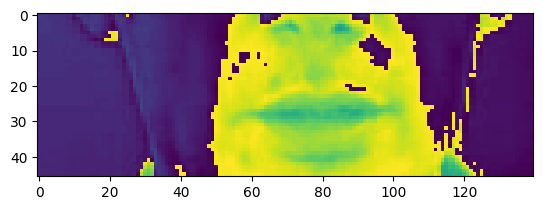

In [12]:
plt.imshow(frames[15])

**
Sets up a TensorFlow data pipeline for loading lipreading data from video file**

In [13]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [14]:
data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
data = data.shuffle(500,reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# # ADDED DOR SPLIT
train = data.take(450)
test = data.skip(450)

In [15]:
frames, alighnments = data.as_numpy_iterator().next()

In [16]:
sample = data.as_numpy_iterator()

In [17]:
val = sample.next();val[0]

array([[[[[1.4938594 ],
          [1.4227233 ],
          [1.4582913 ],
          ...,
          [0.35568082],
          [0.3912489 ],
          [0.3912489 ]],

         [[1.3871552 ],
          [1.3871552 ],
          [1.4582913 ],
          ...,
          [0.35568082],
          [0.3912489 ],
          [0.3912489 ]],

         [[1.5294275 ],
          [1.5294275 ],
          [1.5649956 ],
          ...,
          [0.42681697],
          [0.32011274],
          [0.32011274]],

         ...,

         [[1.1026106 ],
          [1.0670425 ],
          [1.0670425 ],
          ...,
          [0.10670424],
          [0.07113616],
          [0.07113616]],

         [[1.0670425 ],
          [1.0670425 ],
          [1.0670425 ],
          ...,
          [0.07113616],
          [0.07113616],
          [0.07113616]],

         [[1.0670425 ],
          [1.0670425 ],
          [1.0670425 ],
          ...,
          [0.03556808],
          [0.03556808],
          [0.03556808]]],


        [[[1.4938

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D,Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [19]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [20]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [22]:
yhat = model.predict(val[0])

1/1 [==============================] - 3s 3s/step


In [23]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [24]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [25]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [26]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)

In [27]:
history = model.fit(train, validation_data=test, epochs=50, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/50
129/450 [=======>......................] - ETA: 4:03 - loss: 99.1300

[mpeg1video @ 0x7f247c04e880] ac-tex damaged at 22 17
[mpeg1video @ 0x7f247c04e880] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 83.6291

[mpeg1video @ 0x7f23280541c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f23280541c0] Warning MVs not available
[mpeg1video @ 0x7f1ed8099700] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1ed8099700] Warning MVs not available


1/1 [==============================] - 2s 2s/step
Original: setgreenithdthreeagain
Prediction: leee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placebluebyieightno
Prediction: leeee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 830s 2s/step - loss: 83.6291 - val_loss: 69.6895 - lr: 1.0000e-04
Epoch 2/50
210/450 [=============>................] - ETA: 3:02 - loss: 72.3929

[mpeg1video @ 0x7f230c0547c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f230c0547c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 70.9559

[mpeg1video @ 0x7f248807be00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f248807be00] Warning MVs not available


1/1 [==============================] - 0s 119ms/step
Original: setblueinnzeroplease
Prediction: laeeeeoo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layredinqeightplease
Prediction: laeeeioo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 603s 1s/step - loss: 70.9559 - val_loss: 65.3851 - lr: 1.0000e-04
Epoch 3/50
194/450 [===========>..................] - ETA: 3:19 - loss: 67.2484

[mpeg1video @ 0x7f22e8040000] ac-tex damaged at 22 17
[mpeg1video @ 0x7f22e8040000] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 66.2786

[mpeg1video @ 0x7f232c051480] ac-tex damaged at 22 17
[mpeg1video @ 0x7f232c051480] Warning MVs not available


1/1 [==============================] - 0s 119ms/step
Original: binhiteithnsevensoon
Prediction: laeeeea
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setgreenatcfourspplease
Prediction: laeeee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 598s 1s/step - loss: 66.2786 - val_loss: 61.1066 - lr: 1.0000e-04
Epoch 4/50
 78/450 [====>.........................] - ETA: 4:40 - loss: 64.4186

[mpeg1video @ 0x7f1ee4003a00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1ee4003a00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 63.3018

[mpeg1video @ 0x7f22f4feec80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f22f4feec80] Warning MVs not available


1/1 [==============================] - 0s 131ms/step
Original: sethiteithpthreesoon
Prediction: laeeteeo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: sethiteinhnineagain
Prediction: laeeteea
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 599s 1s/step - loss: 63.3018 - val_loss: 59.4550 - lr: 1.0000e-04
Epoch 5/50
115/450 [======>.......................] - ETA: 4:14 - loss: 61.9095

[mpeg1video @ 0x7f248c02ca00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f248c02ca00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 61.5171

[mpeg1video @ 0x7f1eec053d80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1eec053d80] Warning MVs not available


1/1 [==============================] - 0s 122ms/step
Original: laygreenbyssixno
Prediction: laeteea
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bingreenithioneagain
Prediction: laeteeo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 612s 1s/step - loss: 61.5171 - val_loss: 56.5051 - lr: 1.0000e-04
Epoch 6/50
 90/450 [=====>........................] - ETA: 4:41 - loss: 59.9505

[mpeg1video @ 0x7f23d0052300] ac-tex damaged at 22 17
[mpeg1video @ 0x7f23d0052300] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 59.4880

[mpeg1video @ 0x5ce308bdfb00] ac-tex damaged at 22 17
[mpeg1video @ 0x5ce308bdfb00] Warning MVs not available


1/1 [==============================] - 0s 119ms/step
Original: layblueithynineagain
Prediction: laeeo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bingreenathonesoon
Prediction: lareeo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 599s 1s/step - loss: 59.4880 - val_loss: 54.9119 - lr: 1.0000e-04
Epoch 7/50
421/450 [===========================>..] - ETA: 22s - loss: 55.6094

[mpeg1video @ 0x7f2328040880] ac-tex damaged at 22 17
[mpeg1video @ 0x7f2328040880] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 55.6141

[mpeg1video @ 0x7f24880467c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f24880467c0] Warning MVs not available


1/1 [==============================] - 0s 118ms/step
Original: placeredatcsevensoon
Prediction: lareteea
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placegreenithrfivesoon
Prediction: lareea
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 602s 1s/step - loss: 55.6141 - val_loss: 51.6188 - lr: 1.0000e-04
Epoch 8/50
221/450 [=============>................] - ETA: 2:54 - loss: 54.9245

[mpeg1video @ 0x7f22f4e9c240] ac-tex damaged at 22 17
[mpeg1video @ 0x7f22f4e9c240] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 54.4117

[mpeg1video @ 0x7f2330016280] ac-tex damaged at 22 17
[mpeg1video @ 0x7f2330016280] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: layhiteinyeightplease
Prediction: lareteea
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binblueatlsixno
Prediction: laretee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 594s 1s/step - loss: 54.4117 - val_loss: 51.5746 - lr: 1.0000e-04
Epoch 9/50
 98/450 [=====>........................] - ETA: 4:27 - loss: 53.4476

[mpeg1video @ 0x7f1ee4016c00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1ee4016c00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 52.7619

[mpeg1video @ 0x7f23046c8480] ac-tex damaged at 22 17
[mpeg1video @ 0x7f23046c8480] Warning MVs not available


1/1 [==============================] - 0s 124ms/step
Original: binbluebyzeightno
Prediction: lareteo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placegreenatyonesoon
Prediction: lareteo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 598s 1s/step - loss: 52.7619 - val_loss: 49.6273 - lr: 1.0000e-04
Epoch 10/50
 62/450 [===>..........................] - ETA: 4:55 - loss: 51.3707

[mpeg1video @ 0x7f249c0b3700] ac-tex damaged at 22 17
[mpeg1video @ 0x7f249c0b3700] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 51.2865

[mpeg1video @ 0x7f22f000ccc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f22f000ccc0] Warning MVs not available


1/1 [==============================] - 0s 118ms/step
Original: binredithnonesoon
Prediction: laretoo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binhiteinmsevenagain
Prediction: lareteea
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 598s 1s/step - loss: 51.2865 - val_loss: 46.0629 - lr: 1.0000e-04
Epoch 11/50
 30/450 [=>............................] - ETA: 5:22 - loss: 49.8967

[mpeg1video @ 0x7f2470079c00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f2470079c00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 49.0246

[mpeg1video @ 0x7f1ee407ea80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1ee407ea80] Warning MVs not available


1/1 [==============================] - 0s 128ms/step
Original: sethiteatbeightplease
Prediction: larebeeae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setredatufourplease
Prediction: laretelae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 583s 1s/step - loss: 49.0246 - val_loss: 44.1431 - lr: 1.0000e-04
Epoch 12/50
178/450 [==========>...................] - ETA: 3:23 - loss: 47.6867

[mpeg1video @ 0x7f2328071100] ac-tex damaged at 22 17
[mpeg1video @ 0x7f2328071100] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 46.9662

[mpeg1video @ 0x7f248c0e23c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f248c0e23c0] Warning MVs not available


1/1 [==============================] - 0s 121ms/step
Original: layredbylonesoon
Prediction: laretoo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binredithtsixplease
Prediction: lareteplase
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 586s 1s/step - loss: 46.9662 - val_loss: 42.3823 - lr: 1.0000e-04
Epoch 13/50
226/450 [==============>...............] - ETA: 2:49 - loss: 44.5376

[mpeg1video @ 0x7f1e8df186c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1e8df186c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 44.5322

[mpeg1video @ 0x7f2334026280] ac-tex damaged at 22 17
[mpeg1video @ 0x7f2334026280] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: laygreenbymtono
Prediction: lareteo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binhiteithutoplease
Prediction: lareteplase
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 588s 1s/step - loss: 44.5322 - val_loss: 39.0888 - lr: 1.0000e-04
Epoch 14/50
 44/450 [=>............................] - ETA: 5:08 - loss: 41.8998

[mpeg1video @ 0x7f22e805b440] ac-tex damaged at 22 17
[mpeg1video @ 0x7f22e805b440] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 42.2134

[mpeg1video @ 0x7f23241d8400] ac-tex damaged at 22 17
[mpeg1video @ 0x7f23241d8400] Warning MVs not available


1/1 [==============================] - 0s 118ms/step
Original: binredithntoplease
Prediction: setreitelae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layredinythreeagain
Prediction: setreitieain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 587s 1s/step - loss: 42.2134 - val_loss: 37.1951 - lr: 1.0000e-04
Epoch 15/50
241/450 [===============>..............] - ETA: 2:37 - loss: 40.1446

[mpeg1video @ 0x7f249404ad40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f249404ad40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 39.8787

[mpeg1video @ 0x7f22f00522c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f22f00522c0] Warning MVs not available


1/1 [==============================] - 0s 118ms/step
Original: placehiteindzeroplease
Prediction: plableitoplase
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placegreenatythreeagain
Prediction: placereitieain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 591s 1s/step - loss: 39.8787 - val_loss: 34.4220 - lr: 1.0000e-04
Epoch 16/50
405/450 [==========================>...] - ETA: 33s - loss: 37.5430

[mpeg1video @ 0x7f24701ac680] ac-tex damaged at 22 17
[mpeg1video @ 0x7f24701ac680] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 37.5734

[mpeg1video @ 0x7f1ef008ff80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1ef008ff80] Warning MVs not available


1/1 [==============================] - 0s 122ms/step
Original: bingreenatnfivesoon
Prediction: setreitoeson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layhitebyzsixplease
Prediction: larebtieplase
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 573s 1s/step - loss: 37.5734 - val_loss: 32.3877 - lr: 1.0000e-04
Epoch 17/50
341/450 [=====================>........] - ETA: 1:20 - loss: 35.8662

[mpeg1video @ 0x7f232c01ff80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f232c01ff80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 35.6136

[mpeg1video @ 0x7f24980ad200] ac-tex damaged at 22 17
[mpeg1video @ 0x7f24980ad200] Warning MVs not available


1/1 [==============================] - 0s 122ms/step
Original: placehiteatqthreeagain
Prediction: plachieitieain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setgreeninonineagain
Prediction: setreiteain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 577s 1s/step - loss: 35.6136 - val_loss: 30.8727 - lr: 1.0000e-04
Epoch 18/50
 73/450 [===>..........................] - ETA: 4:43 - loss: 32.9562

[mpeg1video @ 0x7f2300080e80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f2300080e80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 33.3629

[mpeg1video @ 0x7f23d0020640] ac-tex damaged at 22 17
[mpeg1video @ 0x7f23d0020640] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: placeredinieightplease
Prediction: placereitieplase
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setredinnsevenagain
Prediction: setreitieain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 586s 1s/step - loss: 33.3629 - val_loss: 28.6786 - lr: 1.0000e-04
Epoch 19/50
120/450 [=======>......................] - ETA: 4:05 - loss: 30.8992

[mpeg1video @ 0x7f1ef4106700] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1ef4106700] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 30.9883

[mpeg1video @ 0x7f23300f4f00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f23300f4f00] Warning MVs not available


1/1 [==============================] - 0s 128ms/step
Original: laygreenatlninesoon
Prediction: lagrenitieson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placeblueatisevenagain
Prediction: placeblueitieagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 580s 1s/step - loss: 30.9883 - val_loss: 25.4471 - lr: 1.0000e-04
Epoch 20/50
187/450 [===========>..................] - ETA: 3:16 - loss: 28.9235

[mpeg1video @ 0x7f1ee4053600] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1ee4053600] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 28.6924

[mpeg1video @ 0x7f22f96d34c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f22f96d34c0] Warning MVs not available


1/1 [==============================] - 0s 126ms/step
Original: setgreenatinineagain
Prediction: setgreitieagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layhitebyftono
Prediction: layhiebyoro
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 582s 1s/step - loss: 28.6924 - val_loss: 22.7521 - lr: 1.0000e-04
Epoch 21/50
112/450 [======>.......................] - ETA: 4:12 - loss: 27.3078

[mpeg1video @ 0x7f24980b2b80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f24980b2b80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 26.6064

[mpeg1video @ 0x7f22e40bbc40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f22e40bbc40] Warning MVs not available


1/1 [==============================] - 0s 125ms/step
Original: sethiteinbtono
Prediction: sethieitoo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layhitebysonesoon
Prediction: layhrebyeson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 586s 1s/step - loss: 26.6064 - val_loss: 20.7822 - lr: 1.0000e-04
Epoch 22/50
218/450 [=============>................] - ETA: 2:59 - loss: 24.9021

[mpeg1video @ 0x7f232c042cc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f232c042cc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 24.6800

[mpeg1video @ 0x7f1ee4037e40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1ee4037e40] Warning MVs not available


1/1 [==============================] - 0s 126ms/step
Original: layhiteinkeightno
Prediction: layhiteatihtno
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layredbyyninesoon
Prediction: layredbynenson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 595s 1s/step - loss: 24.6800 - val_loss: 19.1524 - lr: 1.0000e-04
Epoch 23/50
385/450 [========================>.....] - ETA: 48s - loss: 22.4477

[mpeg1video @ 0x7f23241e7940] ac-tex damaged at 22 17
[mpeg1video @ 0x7f23241e7940] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 22.2709

[mpeg1video @ 0x7f249808e4c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f249808e4c0] Warning MVs not available


1/1 [==============================] - 0s 124ms/step
Original: placeblueinofivesoon
Prediction: placeblueinfveson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setgreeninbninesoon
Prediction: setgreninineson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 581s 1s/step - loss: 22.2709 - val_loss: 16.5814 - lr: 1.0000e-04
Epoch 24/50
191/450 [===========>..................] - ETA: 3:13 - loss: 20.7148

[mpeg1video @ 0x7f22f00102c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f22f00102c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 20.5569

[mpeg1video @ 0x7f23b406c1c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f23b406c1c0] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: placegreenatqnineagain
Prediction: placegreninineagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layhiteithzeightno
Prediction: layhiteitirtno
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 576s 1s/step - loss: 20.5569 - val_loss: 15.8751 - lr: 1.0000e-04
Epoch 25/50
 57/450 [==>...........................] - ETA: 4:50 - loss: 19.1516

[mpeg1video @ 0x7f1ee40ec5c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1ee40ec5c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 19.2581

[mpeg1video @ 0x7f2300085d80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f2300085d80] Warning MVs not available


1/1 [==============================] - 0s 120ms/step
Original: layblueindfiveagain
Prediction: layblueinfveagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setgreenithpninesoon
Prediction: setgrenithsneson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 582s 1s/step - loss: 19.2581 - val_loss: 15.0517 - lr: 1.0000e-04
Epoch 26/50
341/450 [=====================>........] - ETA: 1:22 - loss: 17.8837

[mpeg1video @ 0x5ce3082fd6c0] ac-tex damaged at 22 17
[mpeg1video @ 0x5ce3082fd6c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 17.9579

[mpeg1video @ 0x7f22f4b384c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f22f4b384c0] Warning MVs not available


1/1 [==============================] - 0s 120ms/step
Original: placehiteithqninesoon
Prediction: placehiteithieson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layredatrzerono
Prediction: layredationo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 588s 1s/step - loss: 17.9579 - val_loss: 13.2421 - lr: 1.0000e-04
Epoch 27/50
269/450 [================>.............] - ETA: 2:16 - loss: 16.4772

[mpeg1video @ 0x7f23d01b5340] ac-tex damaged at 22 17
[mpeg1video @ 0x7f23d01b5340] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 16.7433

[mpeg1video @ 0x7f1ee401a140] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1ee401a140] Warning MVs not available


1/1 [==============================] - 0s 128ms/step
Original: sethiteatbsixno
Prediction: sethiteatsixno
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binhiteithhfiveagain
Prediction: binhiteithfiveagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 585s 1s/step - loss: 16.7433 - val_loss: 12.9726 - lr: 1.0000e-04
Epoch 28/50
219/450 [=============>................] - ETA: 2:53 - loss: 15.6770

[mpeg1video @ 0x7f2328008740] ac-tex damaged at 22 17
[mpeg1video @ 0x7f2328008740] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 15.5698

[mpeg1video @ 0x7f249c10f280] ac-tex damaged at 22 17
[mpeg1video @ 0x7f249c10f280] Warning MVs not available


1/1 [==============================] - 0s 124ms/step
Original: layhitespinefourno
Prediction: layhiteinforno
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bingreeningeightplease
Prediction: bingreningihplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 584s 1s/step - loss: 15.5698 - val_loss: 12.0639 - lr: 1.0000e-04
Epoch 29/50
286/450 [==================>...........] - ETA: 2:08 - loss: 14.9126

[mpeg1video @ 0x7f230007f400] ac-tex damaged at 22 17
[mpeg1video @ 0x7f230007f400] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 14.6896

[mpeg1video @ 0x7f247c036900] ac-tex damaged at 22 17
[mpeg1video @ 0x7f247c036900] Warning MVs not available


1/1 [==============================] - 0s 119ms/step
Original: layblueatkzerono
Prediction: layblueatzono
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binblueithtoneagain
Prediction: binblueithoneagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 602s 1s/step - loss: 14.6896 - val_loss: 10.5843 - lr: 1.0000e-04
Epoch 30/50
 36/450 [=>............................] - ETA: 5:13 - loss: 14.5778

[mpeg1video @ 0x7f1eec1d7280] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1eec1d7280] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 14.0600

[mpeg1video @ 0x7f23240c6540] ac-tex damaged at 22 17
[mpeg1video @ 0x7f23240c6540] Warning MVs not available


1/1 [==============================] - 0s 122ms/step
Original: setblueithbfourplease
Prediction: setblueithfurplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binblueatsonesoon
Prediction: binblueatoneson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 583s 1s/step - loss: 14.0600 - val_loss: 10.0082 - lr: 1.0000e-04
Epoch 31/50
332/450 [=====================>........] - ETA: 1:28 - loss: 12.7964

[mpeg1video @ 0x7f1ed8097980] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1ed8097980] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 12.7573

[mpeg1video @ 0x7f1e8cf07d40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1e8cf07d40] Warning MVs not available


1/1 [==============================] - 0s 118ms/step
Original: setredithosixno
Prediction: setredithixno
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: laygreenithgfiveagain
Prediction: laygrenithfiveagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 585s 1s/step - loss: 12.7573 - val_loss: 9.5004 - lr: 9.0484e-05
Epoch 32/50
344/450 [=====================>........] - ETA: 1:22 - loss: 11.9691

[mpeg1video @ 0x7f247c02dd80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f247c02dd80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 11.9446

[mpeg1video @ 0x7f1ef409f180] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1ef409f180] Warning MVs not available


1/1 [==============================] - 0s 127ms/step
Original: binhiteingzerono
Prediction: binhiteinerno
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placegreenatkfiveagain
Prediction: placegrenatfiveagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 599s 1s/step - loss: 11.9446 - val_loss: 8.6576 - lr: 8.1873e-05
Epoch 33/50
 32/450 [=>............................] - ETA: 5:13 - loss: 11.6035

[mpeg1video @ 0x7f233006a040] ac-tex damaged at 22 17
[mpeg1video @ 0x7f233006a040] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 11.3436

[mpeg1video @ 0x7f2494055600] ac-tex damaged at 22 17
[mpeg1video @ 0x7f2494055600] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: layblueinxsixplease
Prediction: layblueinsixplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layblueinxfourno
Prediction: layblueinforno
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 589s 1s/step - loss: 11.3436 - val_loss: 7.7046 - lr: 7.4082e-05
Epoch 34/50
157/450 [=========>....................] - ETA: 3:42 - loss: 10.5389

[mpeg1video @ 0x7f230c098ec0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f230c098ec0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 10.6169

[mpeg1video @ 0x7f2488194100] ac-tex damaged at 22 17
[mpeg1video @ 0x7f2488194100] Warning MVs not available


1/1 [==============================] - 0s 124ms/step
Original: placehiteinjthreesoon
Prediction: placehiteinthreson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binredatssevensoon
Prediction: binredatseveson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 579s 1s/step - loss: 10.6169 - val_loss: 7.0298 - lr: 6.7032e-05
Epoch 35/50
369/450 [=======================>......] - ETA: 1:00 - loss: 10.1051

[mpeg1video @ 0x7f1e8cf86380] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1e8cf86380] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 10.0754

[mpeg1video @ 0x7f2334045540] ac-tex damaged at 22 17
[mpeg1video @ 0x7f2334045540] Warning MVs not available


1/1 [==============================] - 0s 120ms/step
Original: laybluebyroneagain
Prediction: laybluebyoneagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bingreenbyutono
Prediction: bingrenbyuono
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 578s 1s/step - loss: 10.0754 - val_loss: 7.2232 - lr: 6.0653e-05
Epoch 36/50
 69/450 [===>..........................] - ETA: 4:42 - loss: 10.4528

[mpeg1video @ 0x7f1ed80a4100] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1ed80a4100] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 9.6644

[mpeg1video @ 0x7f22f8ec8180] ac-tex damaged at 22 17
[mpeg1video @ 0x7f22f8ec8180] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: layblueatxeightno
Prediction: layblueateightno
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bingreenintsevenagain
Prediction: bingreninsevenagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 576s 1s/step - loss: 9.6644 - val_loss: 6.6332 - lr: 5.4881e-05
Epoch 37/50
 69/450 [===>..........................] - ETA: 4:40 - loss: 9.2255

[mpeg1video @ 0x7f248c052ac0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f248c052ac0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 9.0418

[mpeg1video @ 0x7f1ef4024c80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1ef4024c80] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: sethitebyifivesoon
Prediction: sethitebyfiveson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placegreenbyyfivesoon
Prediction: placegrenbyyfiveson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 574s 1s/step - loss: 9.0418 - val_loss: 5.6027 - lr: 4.9659e-05
Epoch 38/50
193/450 [===========>..................] - ETA: 3:09 - loss: 8.6791

[mpeg1video @ 0x7f23b402a640] ac-tex damaged at 22 17
[mpeg1video @ 0x7f23b402a640] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 8.5440

[mpeg1video @ 0x7f1ee0200340] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1ee0200340] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: layredatefiveagain
Prediction: layredatfiveagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setgreeninvtoplease
Prediction: setgreninoplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 573s 1s/step - loss: 8.5440 - val_loss: 5.4895 - lr: 4.4933e-05
Epoch 39/50
 72/450 [===>..........................] - ETA: 4:41 - loss: 8.5280

[mpeg1video @ 0x7f23280ad900] ac-tex damaged at 22 17
[mpeg1video @ 0x7f23280ad900] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 8.1953

[mpeg1video @ 0x7f2498016400] ac-tex damaged at 22 17
[mpeg1video @ 0x7f2498016400] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: placeblueinionesoon
Prediction: placeblueinoneson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binredbyaoneagain
Prediction: binredbyoneagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 571s 1s/step - loss: 8.1953 - val_loss: 5.3088 - lr: 4.0657e-05
Epoch 40/50
 30/450 [=>............................] - ETA: 5:08 - loss: 8.0891

[mpeg1video @ 0x7f22f8d95080] ac-tex damaged at 22 17
[mpeg1video @ 0x7f22f8d95080] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.9877

[mpeg1video @ 0x7f2334086f40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f2334086f40] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: layredatefourplease
Prediction: layredatfourplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bingreenatnfourno
Prediction: bingrenatfourno
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 567s 1s/step - loss: 7.9877 - val_loss: 4.6099 - lr: 3.6788e-05
Epoch 41/50
376/450 [========================>.....] - ETA: 54s - loss: 7.6234

[mpeg1video @ 0x7f1eec08fc40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1eec08fc40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.5807

[mpeg1video @ 0x7f232402d500] ac-tex damaged at 22 17
[mpeg1video @ 0x7f232402d500] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: layredithlsixplease
Prediction: layredithsixplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: sethiteinotoplease
Prediction: sethiteinoplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 568s 1s/step - loss: 7.5807 - val_loss: 5.0414 - lr: 3.3287e-05
Epoch 42/50
357/450 [======================>.......] - ETA: 1:08 - loss: 7.2955

[mpeg1video @ 0x5ce308b04f00] ac-tex damaged at 22 17
[mpeg1video @ 0x5ce308b04f00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.2428

[mpeg1video @ 0x7f1e8cf07d40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1e8cf07d40] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: setgreenatvsevenagain
Prediction: setgrenatsevenagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binbluebysfivesoon
Prediction: binbluebyfiveson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 572s 1s/step - loss: 7.2428 - val_loss: 4.5252 - lr: 3.0119e-05
Epoch 43/50
281/450 [=================>............] - ETA: 2:03 - loss: 7.1621

[mpeg1video @ 0x7f247005d8c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f247005d8c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.1721

[mpeg1video @ 0x7f1ee4070740] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1ee4070740] Warning MVs not available


1/1 [==============================] - 0s 126ms/step
Original: binbluebymthreeagain
Prediction: binbluebythreagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binredatmthreesoon
Prediction: binredatthreson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 559s 1s/step - loss: 7.1721 - val_loss: 4.4734 - lr: 2.7253e-05
Epoch 44/50
435/450 [============================>.] - ETA: 10s - loss: 6.7970

[mpeg1video @ 0x7f232403a700] ac-tex damaged at 22 17
[mpeg1video @ 0x7f232403a700] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.7881

[mpeg1video @ 0x7f249c0a9ac0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f249c0a9ac0] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: layredinqsevensoon
Prediction: layredinsevenson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placeredincthreesoon
Prediction: placeredinthreson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 556s 1s/step - loss: 6.7881 - val_loss: 4.0377 - lr: 2.4660e-05
Epoch 45/50
373/450 [=======================>......] - ETA: 56s - loss: 6.5667

[mpeg1video @ 0x7f230004f280] ac-tex damaged at 22 17
[mpeg1video @ 0x7f230004f280] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.5974

[mpeg1video @ 0x7f247c02b5c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f247c02b5c0] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: placeredithdfivesoon
Prediction: placeredithdfiveson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binredinlninesoon
Prediction: binredinnineson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 566s 1s/step - loss: 6.5974 - val_loss: 3.5157 - lr: 2.2313e-05
Epoch 46/50
450/450 [==============================] - ETA: 0s - loss: 6.4102

[mpeg1video @ 0x7f22e80afa80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f22e80afa80] Warning MVs not available
[mpeg1video @ 0x7f233001f4c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f233001f4c0] Warning MVs not available


1/1 [==============================] - 0s 124ms/step
Original: binblueinzzerono
Prediction: binblueinzzerono
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setredatutono
Prediction: setredattono
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 564s 1s/step - loss: 6.4102 - val_loss: 3.5830 - lr: 2.0190e-05
Epoch 47/50
231/450 [==============>...............] - ETA: 2:37 - loss: 6.2190

[mpeg1video @ 0x7f1ee003ae00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1ee003ae00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.2516

[mpeg1video @ 0x7f22f5438700] ac-tex damaged at 22 17
[mpeg1video @ 0x7f22f5438700] Warning MVs not available


1/1 [==============================] - 0s 118ms/step
Original: binblueinlthreesoon
Prediction: binblueinthreson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layredithrninesoon
Prediction: layredithrnineson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 561s 1s/step - loss: 6.2516 - val_loss: 3.3286 - lr: 1.8268e-05
Epoch 48/50
304/450 [===================>..........] - ETA: 1:47 - loss: 6.1635

[mpeg1video @ 0x7f248805c040] ac-tex damaged at 22 17
[mpeg1video @ 0x7f248805c040] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.0827

[mpeg1video @ 0x7f22e8015240] ac-tex damaged at 22 17
[mpeg1video @ 0x7f22e8015240] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: layredinezeroplease
Prediction: layredinzeroplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: sethiteithcfivesoon
Prediction: sethiteithfiveson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 571s 1s/step - loss: 6.0827 - val_loss: 3.5577 - lr: 1.6530e-05
Epoch 49/50
367/450 [=======================>......] - ETA: 1:01 - loss: 6.0128

[mpeg1video @ 0x7f232c09de00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f232c09de00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 5.9823

[mpeg1video @ 0x7f1ed81f5c80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f1ed81f5c80] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Original: placegreenbyrtoplease
Prediction: placegrenbyrtoplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binredbymeightplease
Prediction: binredbyeightplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 569s 1s/step - loss: 5.9823 - val_loss: 3.3993 - lr: 1.4957e-05
Epoch 50/50
419/450 [==========================>...] - ETA: 22s - loss: 5.8197

[mpeg1video @ 0x7f2300064340] ac-tex damaged at 22 17
[mpeg1video @ 0x7f2300064340] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 5.8178

[mpeg1video @ 0x7f2484015100] ac-tex damaged at 22 17
[mpeg1video @ 0x7f2484015100] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: placegreenithenineagain
Prediction: placegrenithnineagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placespblueithxzerono
Prediction: placeblueithzerno
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 569s 1s/step - loss: 5.8178 - val_loss: 3.1619 - lr: 1.3534e-05


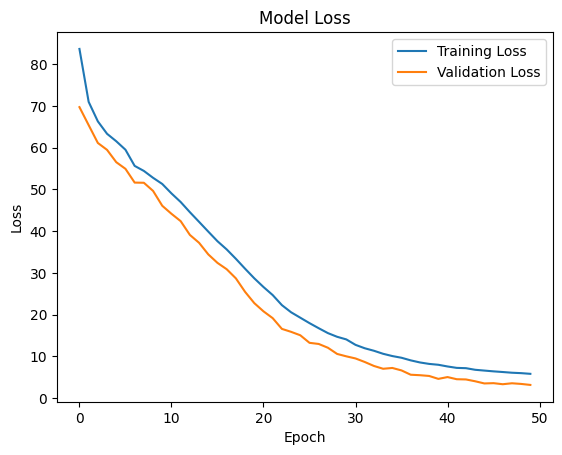

In [28]:

from matplotlib import pyplot as plt
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [29]:
# class AccuracyMetrics(tf.keras.callbacks.Callback):
#     def __init__(self, dataset) -> None:
#         self.dataset = dataset.as_numpy_iterator()
#         self.predictions = []
#         self.ground_truth = []
#         self.accuracies = []  # Store accuracies at each epoch

#     def on_epoch_end(self, epoch, logs=None) -> None:
#         data = self.dataset.next()
#         yhat = self.model.predict(data[0])
#         decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()
#         self.predictions.extend(decoded)
#         self.ground_truth.extend(data[1])

# # ... (your previous code)

# accuracy_metrics = AccuracyMetrics(test)  # Create an instance of AccuracyMetrics

# model.fit(train, validation_data=test, epochs=50, callbacks=[checkpoint_callback, schedule_callback, accuracy_metrics])

# # After training, compute accuracy or any other metric using predictions and ground truth
# predictions = accuracy_metrics.predictions
# ground_truth = accuracy_metrics.ground_truth

# # Compute accuracy (or any other suitable metric) here
# # For example, using sequence_accuracy from Levenshtein distance:
# from nltk.metrics.distance import edit_distance

# def compute_accuracy(preds, truths):
#     acc = sum(edit_distance(pred, truth) for pred, truth in zip(preds, truths)) / len(preds)
#     return 1 - acc

# accuracy = compute_accuracy(predictions, ground_truth)
# print("Accuracy:", accuracy)

In [30]:
# After training, plot the accuracy over epochs
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(accuracy_metrics.accuracies, label='Accuracy')
# plt.xlabel('Epoch')
# plt.legend()
# plt.show()

In [31]:
# Save the model in the native Keras format
from tensorflow.keras.models import save_model
save_model(model, 'models/my_model.keras')


الحمد الله 